In [68]:
import pandas as pd
import plotnine as p9
import math
import numpy as np
from dlhpcstarter.utils import get_melted_config_test_scores

In [69]:
exp_dir = '/scratch/pawsey0864/anicolson/experiments'

In [70]:
configs = [
    {'config': 'single_tf', 'trial': 0, 'name': 'Single CXR (TF)'},
    {'config': 'variable_tf', 'trial': 0, 'name': 'Variable CXR (TF)'},
    {'config': 'longitudinal_gt_prompt_tf', 'trial': 0, 'name': 'GT prompt (TF), GT prompt test'},
    {'config': 'longitudinal_gt_prompt_tf_gen_prompt_test', 'trial': 0, 'name': 'GT prompt (TF), generated prompt test'},
    {'config': 'longitudinal_gen_prompt_cxr-bert', 'trial': 0, 'name': 'Generated prompt (SCST & CXR-BERT), generated prompt test'},
]

In [71]:
df = get_melted_config_test_scores(configs, 'cxrmate_hf', exp_dir)
df.head()

,config,trial,metric,score
0,single_tf,0,test_report_nlg_num_study_ids,1624.0
1,variable_tf,0,test_report_nlg_num_study_ids,1624.0
2,longitudinal_gt_prompt_tf,0,test_report_nlg_num_study_ids,1624.0
3,longitudinal_gt_prompt_tf_gen_prompt_test,0,test_report_nlg_num_study_ids,1624.0
4,single_tf,0,test_report_nlg_num_dicom_ids,2872.0


In [72]:
metrics = {
    'test_report_cxr-bert': 'CXR-BERT',
    'test_report_chexbert_f1_macro': 'CheXbert F1',
    'test_report_nlg_cider': 'CIDEr',
    'test_report_nlg_meteor': 'METEOR',
    'test_report_nlg_rouge': 'ROUGE-L',
    'test_report_nlg_bleu_4': 'B4',
}
df = df[df['metric'].isin(list(metrics.keys()))].copy()
df['metric'] = df['metric'].replace(metrics)
df['metric'] = pd.Categorical(df['metric'], categories=list(metrics.values()))
df.head()


,config,trial,metric,score
20,single_tf,0,B4,0.061294
21,variable_tf,0,B4,0.063849
22,longitudinal_gt_prompt_tf,0,B4,0.061625
23,longitudinal_gt_prompt_tf_gen_prompt_test,0,B4,0.065801
24,single_tf,0,METEOR,0.137853


In [73]:
replace_dict = {i['config']: i['name'] if 'name' in i else i['config'] for i in configs}
df.replace({'config': replace_dict}, inplace=True)
df['config'] = pd.Categorical(df['config'], categories=list(replace_dict.values()))
df.head()

,config,trial,metric,score
20,Single CXR (TF),0,B4,0.061294
21,Variable CXR (TF),0,B4,0.063849
22,"GT prompt (TF), GT prompt test",0,B4,0.061625
23,"GT prompt (TF), generated prompt test",0,B4,0.065801
24,Single CXR (TF),0,METEOR,0.137853


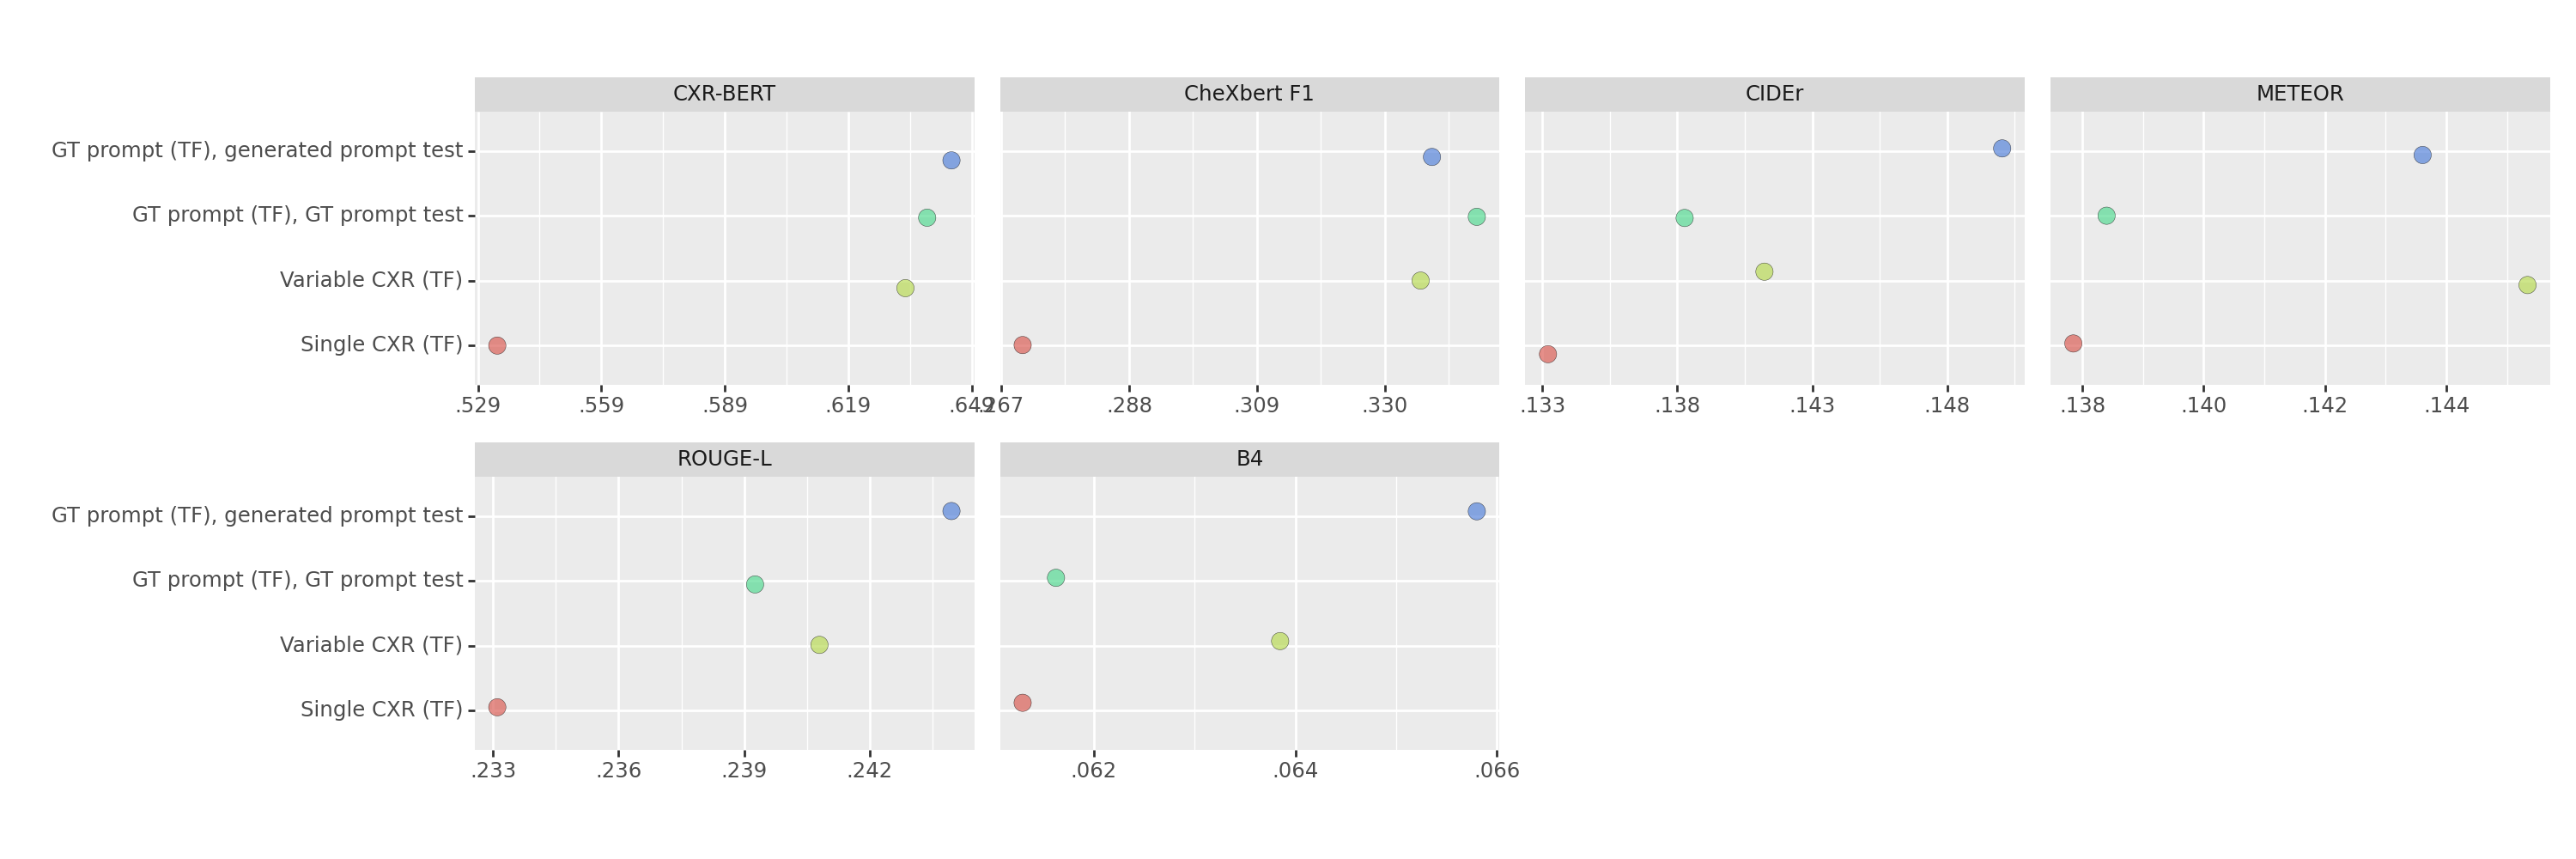

<Figure Size: (1500 x 500)>

In [74]:
def breaks(limits):
    decimals = 3
    factor = 10 ** decimals
    lower_limit = math.ceil(limits[0] * factor) / factor
    upper_limit = math.floor(limits[1] * factor) / factor

    fraction = 10**-decimals
    for spacing in np.arange(fraction, 1, fraction):
        break_points = np.arange(lower_limit, upper_limit + spacing, spacing).tolist()
        if len(break_points) <= 5:
            break
    return break_points

(
    p9.ggplot()
    + p9.geom_jitter(df, p9.aes(
        x='config', y='score', fill='config'), size=4.0, width=0.15, height=0.0, alpha=0.7, stroke=0.1, show_legend=False,
    )
    + p9.facet_wrap(['metric'], ncol=4, scales='free_x')
    + p9.scale_y_continuous(breaks=breaks, labels=lambda x: [("%.3f" % y).lstrip('0') for y in x])
    # + p9.theme_minimal()
    + p9.theme(figure_size=(15, 5))
    + p9.coord_flip() + p9.xlab('') + p9.ylab('')
)